In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import joblib
import sys
sys.path.append('../lib')
from utils import edf_loader, combiner, annotations_reader, find_breakpoints, find_sections,\
                    section_seiz, find_edf
from transformers import SpectrogramTransformer
from models import Baseline, PostProcessing
import time

In [16]:
files1 = find_edf('../dataset/edf/train/01_tcp_ar/')
files2 = find_edf('../dataset/edf/train/02_tcp_le/')
files3 = find_edf('../dataset/edf/train/03_tcp_ar_a/')
files = [files1, files2, files3]

In [17]:
len(files1), len(files2), len(files3)

(3177, 486, 934)

In [18]:
len(files3), len(np.unique(files3))

(934, 934)

In [19]:
len(files1), len(files2), len(files3)

(3177, 486, 934)

In [20]:
len(files3), len(np.unique(files3))

(934, 934)

# Test Baseline class

In [35]:
id_file = 0
file = files1[id_file]
raw = edf_loader(file)
raw.info['montage_type'] = 1
tmax = raw.n_times/raw.info['sfreq']
wd = 8
S = SpectrogramTransformer(win_duration=wd)
montages, spectrograms_db_list = S.fit_transform(raw)

In [41]:
joblib.dump(montages,'montages.dump')

['montages.dump']

In [25]:
file

'../dataset/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/00004456_s012_t002.edf'

In [26]:
from matplotlib import pyplot as plt

In [32]:
len(spectrograms_db_list[0][2])

801

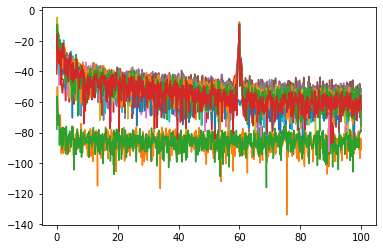

In [34]:
plt.plot(spectrograms_db_list[0][0], spectrograms_db_list[0][2])

In [8]:
def find_seiz_end(predictions, seiz_start):
    seiz_end = seiz_start + 1
    while predictions[seiz_end] and seiz_end < len(predictions)-1:
        seiz_end += 1
    return seiz_end

# Launch pipeline for every folder

In [9]:
def write_predictions(f, basename, predictions, deltaT, wd, tmax):
    seiz_start_list = [seiz_start for seiz_start in range(1,len(predictions)-1)
                                  if not predictions[seiz_start-1] and predictions[seiz_start]]
    seiz_end_list = [find_seiz_end(predictions, seiz_start) for seiz_start in seiz_start_list]
    for seiz_start, seiz_end in zip(seiz_start_list, seiz_end_list):
        t_start = deltaT + seiz_start*wd
        t_end = min(tmax, deltaT + seiz_end*wd)
        f.write('{}\t{}\t{}\t{}\n'.format(basename, t_start, t_end, confidency_level))

In [10]:
%%time
N = 100
wd = 8
confidency_level = 0.9
S = SpectrogramTransformer(win_duration=wd)
B = Baseline(wd)
P = PostProcessing()
with open('../eval/v3.3.1/test_with_PP/hyp.txt', 'w') as f:
    for montage_type, files_list in enumerate(files, 1):
        # for i, file in enumerate(files_list[:N]):
        for i, file in enumerate(files_list):
            print(i, file)
#             basename = os.path.splitext(os.path.basename(file))[0]
            raw = edf_loader(file)
            raw.info['montage_type'] = montage_type
            tmax = raw.n_times/raw.info['sfreq']
            spectrograms_db_list = S.fit_transform(raw)
            B.fit(spectrograms_db_list)
            P.fit(*B.predict())
            deltaT, predictions = P.predict()
            write_predictions(f, basename, predictions, deltaT, wd, tmax)

0 ../dataset/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/00004456_s012_t002.edf
1 ../dataset/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/00004456_s012_t003.edf
2 ../dataset/edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/00004456_s013_t004.edf
3 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t000.edf
4 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t001.edf
5 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t002.edf
6 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t003.edf
7 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t004.edf
8 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t006.edf
9 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t007.edf
10 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t009.edf
11 ../dataset/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/0

96 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t004.edf
97 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t005.edf
98 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t006.edf
99 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t007.edf
100 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t008.edf
101 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t009.edf
102 ../dataset/edf/train/01_tcp_ar/100/00010079/s004_2013_07_02/00010079_s004_t010.edf
103 ../dataset/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/00010088_s005_t000.edf
104 ../dataset/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/00010088_s005_t001.edf
105 ../dataset/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/00010088_s005_t002.edf
106 ../dataset/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/00010088_s005_t003.edf
107 ../dataset/edf/train/01_tcp_ar/100/00010088

191 ../dataset/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/00010088_s014_t007.edf
192 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t000.edf
193 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t001.edf
194 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t002.edf
195 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t003.edf
196 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t004.edf
197 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t005.edf
198 ../dataset/edf/train/01_tcp_ar/100/00010088/s015_2015_03_27/00010088_s015_t006.edf
199 ../dataset/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf
200 ../dataset/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf
201 ../dataset/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/00000254_s006_t001.edf
202 ../dataset/edf/train/01_tcp_ar/002/0000

286 ../dataset/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/00000906_s007_t003.edf
287 ../dataset/edf/train/01_tcp_ar/009/00000906/s014_2012_02_28/00000906_s014_t000.edf
288 ../dataset/edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/00000906_s015_t000.edf
289 ../dataset/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/00000906_s016_t000.edf
290 ../dataset/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/00000906_s016_t001.edf
291 ../dataset/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/00000906_s016_t002.edf
292 ../dataset/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/00000906_s016_t003.edf
293 ../dataset/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/00000906_s016_t004.edf
294 ../dataset/edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/00000906_s017_t000.edf
295 ../dataset/edf/train/01_tcp_ar/009/00000906/s018_2013_01_22/00000906_s018_t000.edf
296 ../dataset/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/00000924_s002_t000.edf
297 ../dataset/edf/train/01_tcp_ar/009/0000

381 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t001.edf
382 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t002.edf
383 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t003.edf
384 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t004.edf
385 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t005.edf
386 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t006.edf
387 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t007.edf
388 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t008.edf
389 ../dataset/edf/train/01_tcp_ar/023/00002348/s012_2015_07_25/00002348_s012_t009.edf
390 ../dataset/edf/train/01_tcp_ar/023/00002348/s013_2015_07_26/00002348_s013_t000.edf
391 ../dataset/edf/train/01_tcp_ar/023/00002348/s013_2015_07_26/00002348_s013_t001.edf
392 ../dataset/edf/train/01_tcp_ar/023/0000

476 ../dataset/edf/train/01_tcp_ar/046/00004671/s022_2015_04_30/00004671_s022_t006.edf
477 ../dataset/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/00005169_s006_t000.edf
478 ../dataset/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/00005169_s006_t001.edf
479 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t000.edf
480 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t001.edf
481 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t002.edf
482 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t005.edf
483 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t006.edf
484 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t014.edf
485 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t017.edf
486 ../dataset/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/00005169_s007_t018.edf
487 ../dataset/edf/train/01_tcp_ar/054/0000

571 ../dataset/edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/00006230_s015_t001.edf
572 ../dataset/edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/00006236_s002_t000.edf
573 ../dataset/edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/00006440_s001_t001.edf
574 ../dataset/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/00006440_s002_t000.edf
575 ../dataset/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/00006440_s002_t001.edf
576 ../dataset/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/00006440_s002_t002.edf
577 ../dataset/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/00006440_s002_t003.edf
578 ../dataset/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/00006440_s003_t000.edf
579 ../dataset/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/00006440_s003_t001.edf
580 ../dataset/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/00006440_s004_t000.edf
581 ../dataset/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/00006440_s004_t001.edf
582 ../dataset/edf/train/01_tcp_ar/064/0000

666 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t005.edf
667 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t006.edf
668 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t007.edf
669 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t008.edf
670 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t009.edf
671 ../dataset/edf/train/01_tcp_ar/065/00006535/s006_2012_07_19/00006535_s006_t010.edf
672 ../dataset/edf/train/01_tcp_ar/065/00006546/s027_2014_01_25/00006546_s027_t000.edf
673 ../dataset/edf/train/01_tcp_ar/065/00006546/s033_2014_03_16/00006546_s033_t000.edf
674 ../dataset/edf/train/01_tcp_ar/065/00006546/s033_2014_03_16/00006546_s033_t001.edf
675 ../dataset/edf/train/01_tcp_ar/065/00006546/s033_2014_03_16/00006546_s033_t002.edf
676 ../dataset/edf/train/01_tcp_ar/065/00006546/s033_2014_03_16/00006546_s033_t003.edf
677 ../dataset/edf/train/01_tcp_ar/065/0000

761 ../dataset/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/00006904_s007_t003.edf
762 ../dataset/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/00006904_s007_t004.edf
763 ../dataset/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/00006904_s007_t005.edf
764 ../dataset/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/00006904_s007_t006.edf
765 ../dataset/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/00006904_s008_t001.edf
766 ../dataset/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/00006904_s008_t002.edf
767 ../dataset/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/00006904_s008_t003.edf
768 ../dataset/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/00007032_s005_t001.edf
769 ../dataset/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/00007032_s005_t002.edf
770 ../dataset/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/00007032_s005_t003.edf
771 ../dataset/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/00007032_s005_t004.edf
772 ../dataset/edf/train/01_tcp_ar/070/0000

856 ../dataset/edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/00007458_s003_t000.edf
857 ../dataset/edf/train/01_tcp_ar/074/00007475/s003_2013_03_22/00007475_s003_t000.edf
858 ../dataset/edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/00007504_s001_t000.edf
859 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t000.edf
860 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t001.edf
861 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t004.edf
862 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t005.edf
863 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t006.edf
864 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t007.edf
865 ../dataset/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/00007555_s008_t008.edf
866 ../dataset/edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/00007584_s004_t000.edf
867 ../dataset/edf/train/01_tcp_ar/076/0000

951 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t000.edf
952 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t001.edf
953 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t002.edf
954 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t003.edf
955 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t004.edf
956 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t005.edf
957 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t006.edf
958 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t007.edf
959 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t008.edf
960 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t009.edf
961 ../dataset/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/00008156_s010_t010.edf
962 ../dataset/edf/train/01_tcp_ar/081/0000

1045 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t001.edf
1046 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t002.edf
1047 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t003.edf
1048 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t004.edf
1049 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t005.edf
1050 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t006.edf
1051 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t007.edf
1052 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t008.edf
1053 ../dataset/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/00008295_s007_t009.edf
1054 ../dataset/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/00008295_s008_t000.edf
1055 ../dataset/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/00008295_s008_t001.edf
1056 ../dataset/edf/train/01_tcp

1139 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t004.edf
1140 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t005.edf
1141 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t006.edf
1142 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t007.edf
1143 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t008.edf
1144 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t010.edf
1145 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t011.edf
1146 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t012.edf
1147 ../dataset/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/00008444_s003_t009.edf
1148 ../dataset/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/00008444_s004_t000.edf
1149 ../dataset/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/00008444_s004_t001.edf
1150 ../dataset/edf/train/01_tcp

1233 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t001.edf
1234 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t002.edf
1235 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t003.edf
1236 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t004.edf
1237 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t005.edf
1238 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t006.edf
1239 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t007.edf
1240 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t008.edf
1241 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t009.edf
1242 ../dataset/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/00008492_s005_t010.edf
1243 ../dataset/edf/train/01_tcp_ar/085/00008527/s002_2015_01_23/00008527_s002_t000.edf
1244 ../dataset/edf/train/01_tcp

1327 ../dataset/edf/train/01_tcp_ar/086/00008615/s001_2012_01_13/00008615_s001_t001.edf
1328 ../dataset/edf/train/01_tcp_ar/086/00008615/s002_2012_06_19/00008615_s002_t000.edf
1329 ../dataset/edf/train/01_tcp_ar/086/00008616/s001_2012_02_22/00008616_s001_t000.edf
1330 ../dataset/edf/train/01_tcp_ar/086/00008628/s001_2012_01_10/00008628_s001_t000.edf
1331 ../dataset/edf/train/01_tcp_ar/086/00008643/s001_2012_02_22/00008643_s001_t000.edf
1332 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t000.edf
1333 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t001.edf
1334 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t002.edf
1335 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t003.edf
1336 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t004.edf
1337 ../dataset/edf/train/01_tcp_ar/086/00008643/s002_2012_02_22/00008643_s002_t005.edf
1338 ../dataset/edf/train/01_tcp

1421 ../dataset/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/00009050_s004_t003.edf
1422 ../dataset/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/00009050_s004_t004.edf
1423 ../dataset/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/00009050_s004_t005.edf
1424 ../dataset/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/00009050_s004_t006.edf
1425 ../dataset/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/00009097_s002_t000.edf
1426 ../dataset/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/00009097_s002_t001.edf
1427 ../dataset/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/00009097_s002_t002.edf
1428 ../dataset/edf/train/01_tcp_ar/091/00009104/s001_2012_08_04/00009104_s001_t000.edf
1429 ../dataset/edf/train/01_tcp_ar/091/00009104/s002_2012_08_04/00009104_s002_t000.edf
1430 ../dataset/edf/train/01_tcp_ar/091/00009104/s002_2012_08_04/00009104_s002_t001.edf
1431 ../dataset/edf/train/01_tcp_ar/091/00009104/s002_2012_08_04/00009104_s002_t002.edf
1432 ../dataset/edf/train/01_tcp

1515 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t010.edf
1516 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t011.edf
1517 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t012.edf
1518 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t009.edf
1519 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t013.edf
1520 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t014.edf
1521 ../dataset/edf/train/01_tcp_ar/091/00009104/s010_2014_09_26/00009104_s010_t015.edf
1522 ../dataset/edf/train/01_tcp_ar/091/00009104/s011_2014_09_29/00009104_s011_t000.edf
1523 ../dataset/edf/train/01_tcp_ar/091/00009104/s012_2014_10_01/00009104_s012_t000.edf
1524 ../dataset/edf/train/01_tcp_ar/091/00009107/s001_2012_05_10/00009107_s001_t000.edf
1525 ../dataset/edf/train/01_tcp_ar/091/00009107/s001_2012_05_10/00009107_s001_t001.edf
1526 ../dataset/edf/train/01_tcp

1609 ../dataset/edf/train/01_tcp_ar/092/00009232/s002_2012_10_10/00009232_s002_t006.edf
1610 ../dataset/edf/train/01_tcp_ar/092/00009232/s002_2012_10_10/00009232_s002_t007.edf
1611 ../dataset/edf/train/01_tcp_ar/092/00009232/s002_2012_10_10/00009232_s002_t008.edf
1612 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t001.edf
1613 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t002.edf
1614 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t003.edf
1615 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t004.edf
1616 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t005.edf
1617 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t006.edf
1618 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t007.edf
1619 ../dataset/edf/train/01_tcp_ar/092/00009232/s004_2012_10_11/00009232_s004_t008.edf
1620 ../dataset/edf/train/01_tcp

1703 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t000.edf
1704 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t001.edf
1705 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t002.edf
1706 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t003.edf
1707 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t004.edf
1708 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t005.edf
1709 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t006.edf
1710 ../dataset/edf/train/01_tcp_ar/095/00009540/s002_2012_11_12/00009540_s002_t007.edf
1711 ../dataset/edf/train/01_tcp_ar/095/00009572/s001_2012_10_23/00009572_s001_t000.edf
1712 ../dataset/edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/00009623_s001_t000.edf
1713 ../dataset/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/00009623_s002_t000.edf
1714 ../dataset/edf/train/01_tcp

1797 ../dataset/edf/train/01_tcp_ar/098/00009852/s003_2013_09_25/00009852_s003_t003.edf
1798 ../dataset/edf/train/01_tcp_ar/098/00009852/s003_2013_09_25/00009852_s003_t004.edf
1799 ../dataset/edf/train/01_tcp_ar/098/00009852/s003_2013_09_25/00009852_s003_t005.edf
1800 ../dataset/edf/train/01_tcp_ar/098/00009852/s003_2013_09_25/00009852_s003_t006.edf
1801 ../dataset/edf/train/01_tcp_ar/098/00009854/s002_2013_04_10/00009854_s002_t000.edf
1802 ../dataset/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/00009880_s001_t000.edf
1803 ../dataset/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/00009880_s001_t001.edf
1804 ../dataset/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/00009880_s002_t000.edf
1805 ../dataset/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/00009880_s002_t001.edf
1806 ../dataset/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/00009880_s002_t002.edf
1807 ../dataset/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/00009880_s002_t003.edf
1808 ../dataset/edf/train/01_tcp

1891 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t002.edf
1892 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t003.edf
1893 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t004.edf
1894 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t005.edf
1895 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t006.edf
1896 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t007.edf
1897 ../dataset/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/00010135_s002_t008.edf
1898 ../dataset/edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/00010148_s001_t000.edf
1899 ../dataset/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/00010158_s001_t000.edf
1900 ../dataset/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/00010158_s001_t001.edf
1901 ../dataset/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/00010158_s003_t000.edf
1902 ../dataset/edf/train/01_tcp

1985 ../dataset/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/00010418_s002_t010.edf
1986 ../dataset/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/00010418_s002_t011.edf
1987 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t000.edf
1988 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t001.edf
1989 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t002.edf
1990 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t003.edf
1991 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t004.edf
1992 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t005.edf
1993 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t006.edf
1994 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t007.edf
1995 ../dataset/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/00010418_s003_t008.edf
1996 ../dataset/edf/train/01_tcp

2079 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t004.edf
2080 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t005.edf
2081 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t006.edf
2082 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t007.edf
2083 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t008.edf
2084 ../dataset/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/00010455_s006_t009.edf
2085 ../dataset/edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/00010461_s001_t000.edf
2086 ../dataset/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/00010480_s003_t000.edf
2087 ../dataset/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/00010480_s003_t001.edf
2088 ../dataset/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/00010480_s003_t002.edf
2089 ../dataset/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/00010480_s003_t003.edf
2090 ../dataset/edf/train/01_tcp

2173 ../dataset/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/00010489_s007_t008.edf
2174 ../dataset/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/00010489_s007_t009.edf
2175 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t000.edf
2176 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t001.edf
2177 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t002.edf
2178 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t003.edf
2179 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t004.edf
2180 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t005.edf
2181 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t006.edf
2182 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t007.edf
2183 ../dataset/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/00010489_s008_t008.edf
2184 ../dataset/edf/train/01_tcp

2267 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t001.edf
2268 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t002.edf
2269 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t003.edf
2270 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t004.edf
2271 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t005.edf
2272 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t006.edf
2273 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t007.edf
2274 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t008.edf
2275 ../dataset/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/00010591_s002_t009.edf
2276 ../dataset/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/00010591_s003_t000.edf
2277 ../dataset/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/00010591_s003_t001.edf
2278 ../dataset/edf/train/01_tcp

2361 ../dataset/edf/train/01_tcp_ar/108/00010843/s009_2014_10_07/00010843_s009_t000.edf
2362 ../dataset/edf/train/01_tcp_ar/108/00010843/s009_2014_10_07/00010843_s009_t001.edf
2363 ../dataset/edf/train/01_tcp_ar/108/00010843/s009_2014_10_07/00010843_s009_t002.edf
2364 ../dataset/edf/train/01_tcp_ar/108/00010843/s009_2014_10_07/00010843_s009_t003.edf
2365 ../dataset/edf/train/01_tcp_ar/108/00010843/s010_2014_10_08/00010843_s010_t000.edf
2366 ../dataset/edf/train/01_tcp_ar/108/00010843/s010_2014_10_08/00010843_s010_t001.edf
2367 ../dataset/edf/train/01_tcp_ar/108/00010843/s010_2014_10_08/00010843_s010_t002.edf
2368 ../dataset/edf/train/01_tcp_ar/108/00010843/s010_2014_10_08/00010843_s010_t003.edf
2369 ../dataset/edf/train/01_tcp_ar/108/00010850/s001_2013_11_07/00010850_s001_t000.edf
2370 ../dataset/edf/train/01_tcp_ar/109/00010912/s002_2014_10_15/00010912_s002_t000.edf
2371 ../dataset/edf/train/01_tcp_ar/109/00010912/s002_2014_10_15/00010912_s002_t001.edf
2372 ../dataset/edf/train/01_tcp

2455 ../dataset/edf/train/01_tcp_ar/110/00011083/s002_2013_12_25/00011083_s002_t002.edf
2456 ../dataset/edf/train/01_tcp_ar/110/00011083/s002_2013_12_25/00011083_s002_t003.edf
2457 ../dataset/edf/train/01_tcp_ar/110/00011083/s002_2013_12_25/00011083_s002_t004.edf
2458 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t000.edf
2459 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t001.edf
2460 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t002.edf
2461 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t003.edf
2462 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t004.edf
2463 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t005.edf
2464 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t006.edf
2465 ../dataset/edf/train/01_tcp_ar/110/00011083/s003_2013_12_25/00011083_s003_t007.edf
2466 ../dataset/edf/train/01_tcp

2549 ../dataset/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/00011333_s026_t007.edf
2550 ../dataset/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/00011333_s026_t008.edf
2551 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t000.edf
2552 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t001.edf
2553 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t002.edf
2554 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t003.edf
2555 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t004.edf
2556 ../dataset/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/00011333_s031_t005.edf
2557 ../dataset/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/00011333_s033_t000.edf
2558 ../dataset/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/00011333_s033_t001.edf
2559 ../dataset/edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/00011333_s035_t000.edf
2560 ../dataset/edf/train/01_tcp

2643 ../dataset/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/00011834_s001_t000.edf
2644 ../dataset/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/00011834_s001_t001.edf
2645 ../dataset/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/00011869_s001_t000.edf
2646 ../dataset/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/00011869_s001_t001.edf
2647 ../dataset/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/00011869_s001_t002.edf
2648 ../dataset/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/00011869_s001_t003.edf
2649 ../dataset/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/00011869_s001_t004.edf
2650 ../dataset/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/00011869_s004_t002.edf
2651 ../dataset/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/00011869_s004_t003.edf
2652 ../dataset/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/00011869_s004_t004.edf
2653 ../dataset/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/00011869_s004_t005.edf
2654 ../dataset/edf/train/01_tcp

2737 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t002.edf
2738 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t003.edf
2739 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t004.edf
2740 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t005.edf
2741 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t006.edf
2742 ../dataset/edf/train/01_tcp_ar/119/00011927/s003_2014_07_09/00011927_s003_t007.edf
2743 ../dataset/edf/train/01_tcp_ar/119/00011972/s001_2014_09_16/00011972_s001_t000.edf
2744 ../dataset/edf/train/01_tcp_ar/119/00011972/s002_2014_09_16/00011972_s002_t000.edf
2745 ../dataset/edf/train/01_tcp_ar/119/00011972/s002_2014_09_16/00011972_s002_t001.edf
2746 ../dataset/edf/train/01_tcp_ar/119/00011972/s002_2014_09_16/00011972_s002_t002.edf
2747 ../dataset/edf/train/01_tcp_ar/119/00011972/s002_2014_09_16/00011972_s002_t003.edf
2748 ../dataset/edf/train/01_tcp

2831 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t003.edf
2832 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t004.edf
2833 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t005.edf
2834 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t006.edf
2835 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t007.edf
2836 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t008.edf
2837 ../dataset/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/00012229_s007_t009.edf
2838 ../dataset/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/00012229_s008_t000.edf
2839 ../dataset/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/00012229_s008_t001.edf
2840 ../dataset/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/00012229_s008_t002.edf
2841 ../dataset/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/00012229_s008_t003.edf
2842 ../dataset/edf/train/01_tcp

../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2923 ../dataset/edf/train/01_tcp_ar/129/00012940/s001_2015_04_26/00012940_s001_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2924 ../dataset/edf/train/01_tcp_ar/129/00012940/s001_2015_04_26/00012940_s001_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2925 ../dataset/edf/train/01_tcp_ar/129/00012940/s001_2015_04_26/00012940_s001_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2926 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2927 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2928 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2929 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2930 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2931 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2932 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2933 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t008.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2934 ../dataset/edf/train/01_tcp_ar/129/00012940/s002_2015_04_26/00012940_s002_t009.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2935 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2936 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2937 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2938 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2939 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2940 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2941 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t007.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2942 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t008.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2943 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t009.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2944 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t010.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2945 ../dataset/edf/train/01_tcp_ar/129/00012940/s003_2015_04_27/00012940_s003_t011.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2946 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2947 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2948 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2949 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2950 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2951 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2952 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2953 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t007.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2954 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t008.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2955 ../dataset/edf/train/01_tcp_ar/129/00012940/s004_2015_04_28/00012940_s004_t009.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2956 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t000.edf
2957 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t001.edf
2958 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t002.edf
2959 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t003.edf
2960 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t004.edf
2961 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t005.edf
2962 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t006.edf
2963 ../dataset/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t007.edf
2964 ../dataset/edf/train/01_tcp_ar/129/00012960/s001_2015_06_17/00012960_s001_t001.edf
2965 ../dataset/edf/train/01_tcp_ar/129/00012960/s002_2015_06_17/00012960_s002_t000.edf
2966 ../dataset/edf/train/01_tcp_ar/129/00012960/s002_2015_06_17/00012960_s002_t001.edf
2967 ../dataset/edf/train/01_tcp

../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2993 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2994 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2995 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2996 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2997 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2998 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


2999 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t008.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3000 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t009.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3001 ../dataset/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t010.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3002 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3003 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3004 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3005 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3006 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3007 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3008 ../dataset/edf/train/01_tcp_ar/129/00012966/s003_2015_09_03/00012966_s003_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3009 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3010 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3011 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3012 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3013 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3014 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3015 ../dataset/edf/train/01_tcp_ar/129/00012966/s004_2015_09_03/00012966_s004_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3016 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t000.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3017 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t001.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3018 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t002.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3019 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t003.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3020 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t004.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3021 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t005.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3022 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t006.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3023 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t007.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3024 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t008.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3025 ../dataset/edf/train/01_tcp_ar/129/00012966/s005_2015_09_04/00012966_s005_t009.edf


../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3026 ../dataset/edf/train/01_tcp_ar/129/00012966/s007_2015_09_05/00012966_s007_t001.edf
3027 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t000.edf
3028 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t001.edf
3029 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t002.edf
3030 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t003.edf
3031 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t004.edf
3032 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t005.edf
3033 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t006.edf
3034 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t007.edf
3035 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t008.edf
3036 ../dataset/edf/train/01_tcp_ar/129/00012966/s009_2015_09_06/00012966_s009_t009.edf
3037 ../dataset/edf/train/01_tcp

../lib/utils.py:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['RESP ABDOMEN-REF']
  raw = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)


3066 ../dataset/edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/00013011_s001_t000.edf
3067 ../dataset/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/00013095_s001_t001.edf
3068 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t000.edf
3069 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t001.edf
3070 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t002.edf
3071 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t003.edf
3072 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t004.edf
3073 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t005.edf
3074 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t006.edf
3075 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t007.edf
3076 ../dataset/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/00013145_s004_t008.edf
3077 ../dataset/edf/train/01_tcp

3160 ../dataset/edf/train/01_tcp_ar/134/00013407/s003_2015_09_30/00013407_s003_t010.edf
3161 ../dataset/edf/train/01_tcp_ar/134/00013407/s003_2015_09_30/00013407_s003_t011.edf
3162 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t000.edf
3163 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t001.edf
3164 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t002.edf
3165 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t003.edf
3166 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t004.edf
3167 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t006.edf
3168 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t007.edf
3169 ../dataset/edf/train/01_tcp_ar/134/00013407/s004_2015_10_01/00013407_s004_t008.edf
3170 ../dataset/edf/train/01_tcp_ar/134/00013407/s005_2015_10_02/00013407_s005_t000.edf
3171 ../dataset/edf/train/01_tcp

78 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t001.edf
79 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t002.edf
80 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t003.edf
81 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t004.edf
82 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t005.edf
83 ../dataset/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t006.edf
84 ../dataset/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/00000499_s002_t001.edf
85 ../dataset/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/00000499_s002_t002.edf
86 ../dataset/edf/train/02_tcp_le/005/00000502/s003_2003_08_12/00000502_s003_t000.edf
87 ../dataset/edf/train/02_tcp_le/005/00000526/s001_2003_08_11/00000526_s001_t000.edf
88 ../dataset/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/00000526_s002_t000.edf
89 ../dataset/edf/train/02_tcp_le/005/00000526/s002_20

173 ../dataset/edf/train/02_tcp_le/016/00001653/s001_2004_01_06/00001653_s001_t000.edf
174 ../dataset/edf/train/02_tcp_le/016/00001681/s001_2004_01_26/00001681_s001_t000.edf
175 ../dataset/edf/train/02_tcp_le/016/00001690/s001_2004_08_10/00001690_s001_t000.edf
176 ../dataset/edf/train/02_tcp_le/016/00001698/s001_2004_02_13/00001698_s001_t001.edf
177 ../dataset/edf/train/02_tcp_le/017/00001753/s003_2006_01_31/00001753_s003_t001.edf
178 ../dataset/edf/train/02_tcp_le/017/00001781/s001_2004_08_04/00001781_s001_t001.edf
179 ../dataset/edf/train/02_tcp_le/017/00001795/s001_2004_08_05/00001795_s001_t001.edf
180 ../dataset/edf/train/02_tcp_le/017/00001797/s001_2004_07_22/00001797_s001_t000.edf
181 ../dataset/edf/train/02_tcp_le/018/00001843/s001_2004_07_29/00001843_s001_t000.edf
182 ../dataset/edf/train/02_tcp_le/018/00001864/s001_2004_01_22/00001864_s001_t001.edf
183 ../dataset/edf/train/02_tcp_le/018/00001878/s001_2004_09_03/00001878_s001_t001.edf
184 ../dataset/edf/train/02_tcp_le/018/0000

268 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t012.edf
269 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t009.edf
270 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t013.edf
271 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t014.edf
272 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t015.edf
273 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t016.edf
274 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t017.edf
275 ../dataset/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/00003101_s003_t018.edf
276 ../dataset/edf/train/02_tcp_le/031/00003144/s001_2006_08_04/00003144_s001_t000.edf
277 ../dataset/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/00003208_s001_t001.edf
278 ../dataset/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/00003208_s001_t002.edf
279 ../dataset/edf/train/02_tcp_le/032/0000

363 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t000.edf
364 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t001.edf
365 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t002.edf
366 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t003.edf
367 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t004.edf
368 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t005.edf
369 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t006.edf
370 ../dataset/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/00005130_s002_t007.edf
371 ../dataset/edf/train/02_tcp_le/051/00005180/s001_2008_06_27/00005180_s001_t000.edf
372 ../dataset/edf/train/02_tcp_le/051/00005183/s001_2008_08_04/00005183_s001_t000.edf
373 ../dataset/edf/train/02_tcp_le/052/00005208/s002_2008_11_18/00005208_s002_t001.edf
374 ../dataset/edf/train/02_tcp_le/052/0000

458 ../dataset/edf/train/02_tcp_le/065/00006514/s024_2010_06_03/00006514_s024_t001.edf
459 ../dataset/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/00006514_s025_t000.edf
460 ../dataset/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/00006514_s025_t001.edf
461 ../dataset/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/00006544_s001_t000.edf
462 ../dataset/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/00006544_s001_t001.edf
463 ../dataset/edf/train/02_tcp_le/067/00006771/s003_2010_11_29/00006771_s003_t000.edf
464 ../dataset/edf/train/02_tcp_le/068/00006811/s004_2010_07_30/00006811_s004_t000.edf
465 ../dataset/edf/train/02_tcp_le/069/00006904/s001_2010_08_20/00006904_s001_t001.edf
466 ../dataset/edf/train/02_tcp_le/070/00007067/s001_2010_02_15/00007067_s001_t001.edf
467 ../dataset/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/00007108_s001_t000.edf
468 ../dataset/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/00007108_s001_t001.edf
469 ../dataset/edf/train/02_tcp_le/071/0000

66 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t002.edf
67 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t003.edf
68 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t004.edf
69 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t005.edf
70 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t006.edf
71 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t007.edf
72 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s011_2010_09_13/00000883_s011_t008.edf
73 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s012_2010_09_13/00000883_s012_t000.edf
74 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s012_2010_09_13/00000883_s012_t001.edf
75 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s012_2010_09_13/00000883_s012_t002.edf
76 ../dataset/edf/train/03_tcp_ar_a/008/00000883/s012_2010_09_13/00000883_s012_t003.edf
77 ../dataset/edf/train/03_tcp_a

159 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t001.edf
160 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t002.edf
161 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t004.edf
162 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t006.edf
163 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t008.edf
164 ../dataset/edf/train/03_tcp_ar_a/023/00002380/s005_2006_01_21/00002380_s005_t010.edf
165 ../dataset/edf/train/03_tcp_ar_a/024/00002427/s005_2006_03_01/00002427_s005_t000.edf
166 ../dataset/edf/train/03_tcp_ar_a/024/00002427/s005_2006_03_01/00002427_s005_t001.edf
167 ../dataset/edf/train/03_tcp_ar_a/024/00002427/s005_2006_03_01/00002427_s005_t002.edf
168 ../dataset/edf/train/03_tcp_ar_a/024/00002427/s005_2006_03_01/00002427_s005_t003.edf
169 ../dataset/edf/train/03_tcp_ar_a/024/00002427/s005_2006_03_01/00002427_s005_t004.edf
170 ../dataset/edf/tr

252 ../dataset/edf/train/03_tcp_ar_a/040/00004008/s002_2007_05_18/00004008_s002_t000.edf
253 ../dataset/edf/train/03_tcp_ar_a/040/00004008/s002_2007_05_18/00004008_s002_t001.edf
254 ../dataset/edf/train/03_tcp_ar_a/040/00004008/s002_2007_05_18/00004008_s002_t002.edf
255 ../dataset/edf/train/03_tcp_ar_a/040/00004008/s002_2007_05_18/00004008_s002_t003.edf
256 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s004_2008_01_11/00004434_s004_t000.edf
257 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s004_2008_01_11/00004434_s004_t001.edf
258 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s004_2008_01_11/00004434_s004_t002.edf
259 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s004_2008_01_11/00004434_s004_t003.edf
260 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s005_2008_01_11/00004434_s005_t000.edf
261 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s005_2008_01_11/00004434_s005_t001.edf
262 ../dataset/edf/train/03_tcp_ar_a/044/00004434/s005_2008_01_11/00004434_s005_t002.edf
263 ../dataset/edf/tr

345 ../dataset/edf/train/03_tcp_ar_a/055/00005512/s004_2009_05_26/00005512_s004_t001.edf
346 ../dataset/edf/train/03_tcp_ar_a/055/00005512/s004_2009_05_26/00005512_s004_t002.edf
347 ../dataset/edf/train/03_tcp_ar_a/055/00005512/s004_2009_05_26/00005512_s004_t003.edf
348 ../dataset/edf/train/03_tcp_ar_a/055/00005512/s004_2009_05_26/00005512_s004_t004.edf
349 ../dataset/edf/train/03_tcp_ar_a/055/00005512/s004_2009_05_26/00005512_s004_t005.edf
350 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t001.edf
351 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t002.edf
352 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t003.edf
353 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t004.edf
354 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t005.edf
355 ../dataset/edf/train/03_tcp_ar_a/056/00005605/s002_2009_01_06/00005605_s002_t006.edf
356 ../dataset/edf/tr

438 ../dataset/edf/train/03_tcp_ar_a/062/00006230/s014_2011_08_03/00006230_s014_t002.edf
439 ../dataset/edf/train/03_tcp_ar_a/062/00006230/s014_2011_08_03/00006230_s014_t003.edf
440 ../dataset/edf/train/03_tcp_ar_a/062/00006230/s014_2011_08_03/00006230_s014_t004.edf
441 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t000.edf
442 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t001.edf
443 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t002.edf
444 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t003.edf
445 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t004.edf
446 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t005.edf
447 ../dataset/edf/train/03_tcp_ar_a/062/00006251/s002_2009_05_18/00006251_s002_t006.edf
448 ../dataset/edf/train/03_tcp_ar_a/064/00006413/s005_2010_02_15/00006413_s005_t000.edf
449 ../dataset/edf/tr

531 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s002_2010_11_02/00007092_s002_t000.edf
532 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s002_2010_11_02/00007092_s002_t001.edf
533 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s002_2010_11_02/00007092_s002_t002.edf
534 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s002_2010_11_02/00007092_s002_t003.edf
535 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s002_2010_11_02/00007092_s002_t004.edf
536 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s003_2010_11_03/00007092_s003_t000.edf
537 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s003_2010_11_03/00007092_s003_t001.edf
538 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s003_2010_11_03/00007092_s003_t002.edf
539 ../dataset/edf/train/03_tcp_ar_a/070/00007092/s003_2010_11_03/00007092_s003_t003.edf
540 ../dataset/edf/train/03_tcp_ar_a/071/00007128/s002_2010_10_12/00007128_s002_t000.edf
541 ../dataset/edf/train/03_tcp_ar_a/071/00007128/s002_2010_10_12/00007128_s002_t001.edf
542 ../dataset/edf/tr

624 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s004_2014_05_14/00007828_s004_t005.edf
625 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s004_2014_05_14/00007828_s004_t006.edf
626 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s004_2014_05_14/00007828_s004_t007.edf
627 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t000.edf
628 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t001.edf
629 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t002.edf
630 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t003.edf
631 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t004.edf
632 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t005.edf
633 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t007.edf
634 ../dataset/edf/train/03_tcp_ar_a/078/00007828/s005_2014_05_15/00007828_s005_t008.edf
635 ../dataset/edf/tr

717 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t005.edf
718 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t006.edf
719 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t008.edf
720 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t009.edf
721 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t010.edf
722 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t011.edf
723 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t012.edf
724 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s018_2014_06_01/00010418_s018_t000.edf
725 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s018_2014_06_01/00010418_s018_t001.edf
726 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s018_2014_06_01/00010418_s018_t002.edf
727 ../dataset/edf/train/03_tcp_ar_a/104/00010418/s018_2014_06_01/00010418_s018_t003.edf
728 ../dataset/edf/tr

810 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t003.edf
811 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t004.edf
812 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t005.edf
813 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t006.edf
814 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t007.edf
815 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t008.edf
816 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t010.edf
817 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t011.edf
818 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t012.edf
819 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t009.edf
820 ../dataset/edf/train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t013.edf
821 ../dataset/edf/tr

903 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t004.edf
904 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t005.edf
905 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t007.edf
906 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t008.edf
907 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t009.edf
908 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t010.edf
909 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t013.edf
910 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t014.edf
911 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t015.edf
912 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t016.edf
913 ../dataset/edf/train/03_tcp_ar_a/130/00013085/s002_2015_10_05/00013085_s002_t011.edf
914 ../dataset/edf/tr